In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

from src.config import MODELS_DIR, URBAN_CLUSTER_FILE, CLUSTER_LABELS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First Attempt: Treating Everyone the Same

As an initial approach, we trained our models using the entire dataset with a simple 80/20 random split. 

This served as a baseline to establish a starting point for comparison. 

We experimented with several models, but the two that stood out were ElasticNet and Gradient Boosting Regressor, as they delivered the best performance. 

In the first run, we achieved an R² score above 91%. Although this seemed promising, a closer look at the actual versus predicted values revealed that the predictions were almost perfect, which seemed suspicious. After a more detailed analysis, we realized that the random split had allowed data from the same city to appear in both the training and test sets. To solve this issue, we decided to use grouped K-Fold cross-validation to ensure that each city appeared only in the training or the test data within each fold.


> 📓 Full first-phase modeling details: [`notebooks/modeling/modeling.ipynb`](notebooks/modeling/modeling.ipynb)

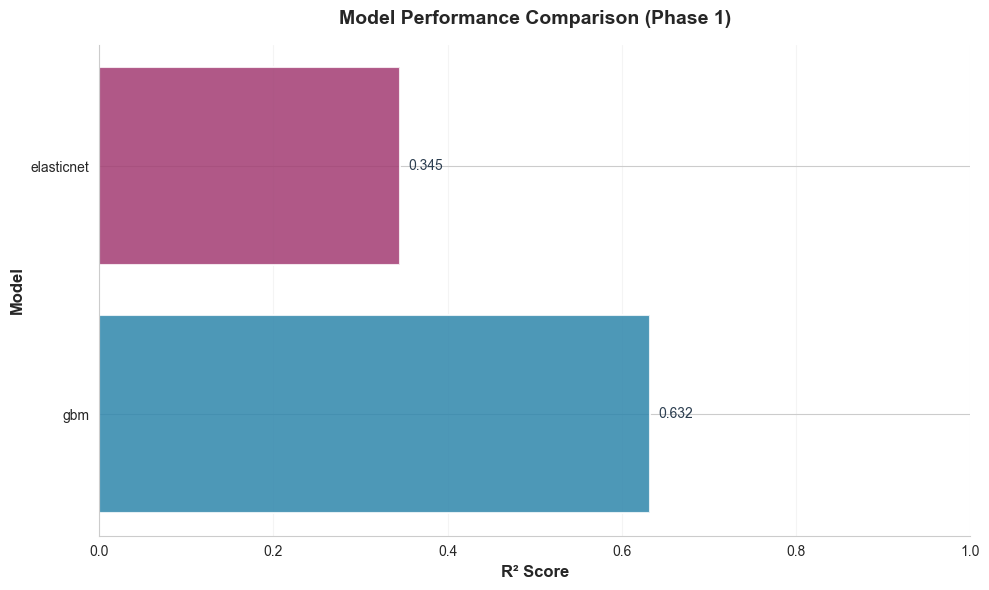

In [34]:
cv_results = pd.read_csv(MODELS_DIR / "cv_results.csv")
cv_results = cv_results[cv_results['Model'].isin(['elasticnet', 'gbm'])]

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')

colors = ['#2E86AB', '#A23B72']
bars = ax.barh(cv_results['Model'], cv_results['Test R²'], color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)

ax.set_xlabel('R² Score', fontsize=12, fontweight='600')
ax.set_ylabel('Model', fontsize=12, fontweight='600')
ax.set_title('Model Performance Comparison (Phase 1)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.2, axis='x')
sns.despine(ax=ax)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center', 
            fontsize=10, color='#2C3E50', fontweight='500')

plt.tight_layout()
plt.show()

# House Pricing Prediction - Modeling Results

### Modeling

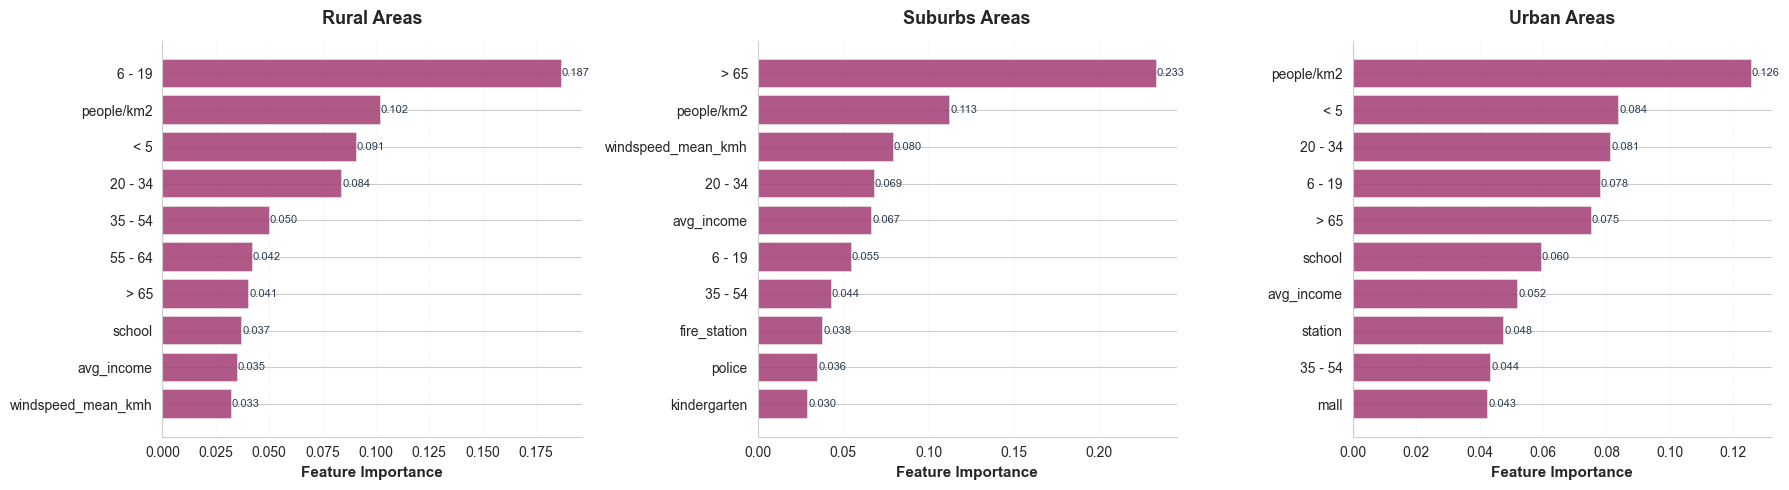

In [35]:
from src.config import MODELS_DIR

importance_df = pd.read_csv(MODELS_DIR / "feature_importance_by_cluster.csv")

gbm_importance = importance_df[importance_df['Model'] == 'gbm']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('white')

clusters = [('Rural', 0), ('Suburbs', 1), ('Urban', 4)]

for idx, (label, cluster_id) in enumerate(clusters):
    cluster_data = gbm_importance[gbm_importance['Cluster ID'] == cluster_id].sort_values(
        'Importance', ascending=False
    ).head(10)
    
    bars = axes[idx].barh(cluster_data['Feature'], cluster_data['Importance'], 
                          color='#A23B72', alpha=0.85, edgecolor='white', linewidth=1.2)
    axes[idx].set_xlabel('Feature Importance', fontsize=11, fontweight='600')
    axes[idx].set_title(f'{label} Areas', fontsize=13, fontweight='bold', pad=12)
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.15, axis='x', linestyle='--')
    sns.despine(ax=axes[idx])
    
    for bar in bars:
        width = bar.get_width()
        axes[idx].text(width, bar.get_y() + bar.get_height()/2, 
                      f'{width:.3f}', ha='left', va='center', 
                      fontsize=8, color='#2C3E50', fontweight='500')

plt.tight_layout()
plt.show()

### Key Insights:

 - Rural Areas:
   - Weather conditions dominate
   - Demographics matter
   - Limited infrastructure means natural amenities are valued (e.g. schools)

- Suburbs:
  - Density plays a significant role
  - Higher incomes are more valuable

- Urban Areas:
  - Density plays the biggest role
  - Everyday ameinities are valued (e.g. malls, school, station)

## So What Actually Makes Houses Expensive?

Here's where it gets really interesting—it totally depends on where you are:

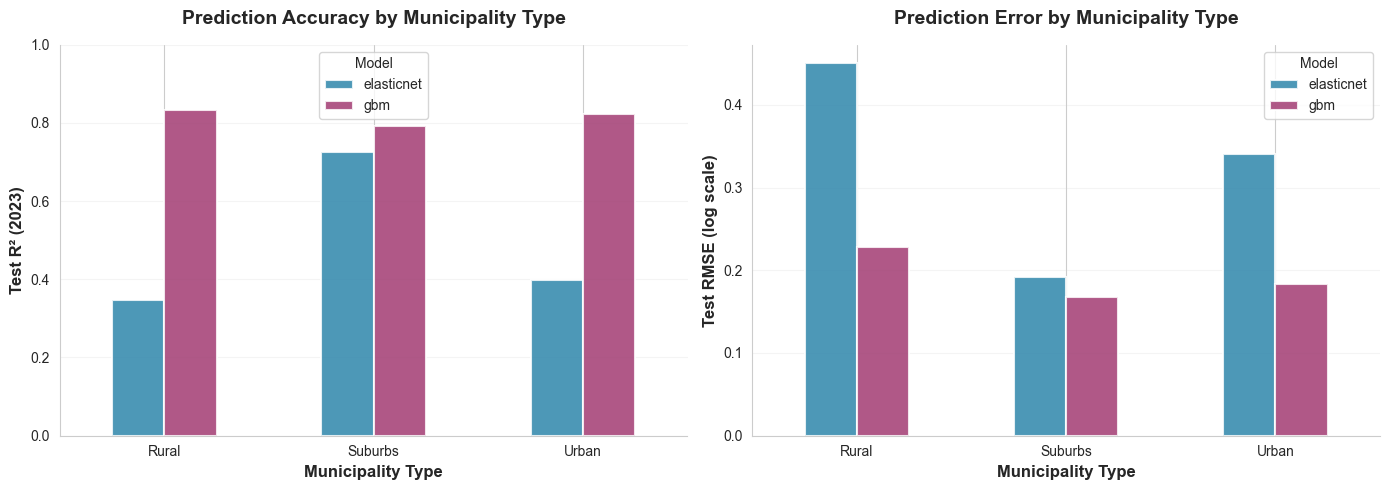

In [36]:
from src.config import MODELS_DIR

results_df = pd.read_csv(MODELS_DIR / "temporal_validation_by_cluster.csv")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('white')

colors = ['#2E86AB', '#A23B72']

pivot_r2 = results_df.pivot(index='Cluster', columns='Model', values='Test R² (2023)')
pivot_r2.plot(kind='bar', ax=axes[0], color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)
axes[0].set_xlabel('Municipality Type', fontsize=12, fontweight='600')
axes[0].set_ylabel('Test R² (2023)', fontsize=12, fontweight='600')
axes[0].set_title('Prediction Accuracy by Municipality Type', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(title='Model', fontsize=10)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(True, alpha=0.2, axis='y')
axes[0].set_ylim(0, 1)
sns.despine(ax=axes[0])

pivot_rmse = results_df.pivot(index='Cluster', columns='Model', values='Test RMSE (2023)')
pivot_rmse.plot(kind='bar', ax=axes[1], color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)
axes[1].set_xlabel('Municipality Type', fontsize=12, fontweight='600')
axes[1].set_ylabel('Test RMSE (log scale)', fontsize=12, fontweight='600')
axes[1].set_title('Prediction Error by Municipality Type', fontsize=14, fontweight='bold', pad=15)
axes[1].legend(title='Model', fontsize=10)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.2, axis='y')
sns.despine(ax=axes[1])

plt.tight_layout()
plt.show()

### Model Results:

- Gradient Boosting is better at predicting the house prices, achieving 72-83%
- Rural areas are easier to predict, compared to more dense areas.
- Non-linear model, is able to capture the complexity of the dataset relationships

**The approach:**
- Trained on 2019-2022 data 
- Tested on 2023
- Used 33 features
- Compared two approaches: ElasticNet (simple) vs Gradient Boosting (complex)

**How did we do?**

| Where | Model | How accurate? 
|-------|-------|---------------
| Rural | GBM | 83% | Small 
| Rural | ElasticNet | 35% | Big
| Suburbs | GBM | 79% | Smal
| Suburbs | ElasticNet | 72% | M
| Urban | GBM | 72% |
| Urban | ElasticNet | 40% 

**What this means:**
Gradient Boosting was the best performance model, because the house prices do not follow simple rules, with features interacting in unexpected ways. This model was capable of capturing that complexity.

>  Full modeling story: [`notebooks/modeling/02_modeling_urban_clusters.ipynb`](notebooks/modeling/02_modeling_urban_clusters.ipynb)

# Conclusion

So we can conclude that the driving factor of house prices, is highly dependable on the location, for example in rural areas the weather is very relevant, but in the other hand, in the urban areas, the population density is the driving factor. 